В этом задании вам предлагается проанализировать данные одной из американских телекоммуникационных компаний о пользователях, которые потенциально могут уйти.

Измерены следующие признаки:

* `state` — штат США
* `account_length` — длительность использования аккаунта
* `area_code` — деление пользователей на псевдорегионы, использующееся в телекоме
* `intl_plan` — подключена ли у пользователя услуга международного общения
* `vmail_plan` — подключена ли у пользователя услуга голосовых сообщений
* `vmail_message` — количество голосых сообщений, который пользователь отправил / принял
* `day_calls` — сколько пользователь совершил дневных звонков
* `day_min`s — сколько пользователь проговорил минут в течение дня
* `day_charge` — сколько пользователь заплатил за свою дневную активность
* `eve_calls`, `eve_mins`, `eve_charge` — аналогичные метрики относительно вечерней активности
* `night_calls`, `night_mins`, `night_charge` — аналогичные метрики относительно ночной активности
* `intl_calls`, `intl_mins`, `intl_charge` — аналогичные метрики относительно международного общения
* `custserv_calls` — сколько раз пользователь позвонил в службу поддержки
* `treatment` — номер стратегии, которая применялись для удержания абонентов (`0`, `2` = два разных типа воздействия, `1` = контрольная группа)
* `mes_estim` — оценка интенсивности пользования интернет мессенджерами
* `churn` — результат оттока: перестал ли абонент пользоваться услугами оператора

In [3]:
import pandas

dataset = pandas.read_csv('churn_analysis.csv', index_col=0)
dataset.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


Давайте рассмотрим всех пользователей из контрольной группы (`treatment = 1`). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.

Для этого мы воспользуемся критерием хи-квадрат. Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака `churn`. Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции

```
scipy.stats.chi2_contingency(subtable, correction=False)
```

Заметьте, что, например, `(AZ, HI)` и `(HI, AZ)` — это одна и та же пара. Обязательно выставьте `correction=False` (о том, что это значит, вы узнаете из следующих вопросов).

✅ Сколько достигаемых уровней значимости оказались меньше, чем α=0.05?

In [27]:
from functools import partial
from itertools import combinations

from scipy import stats

treatment = dataset[dataset['treatment'] == 1]  # FIXME: should be treatment_1
treatment_crosstab = pandas.crosstab(treatment['state'], treatment['churn'])

def state_test(test):
    return sum(
        test(treatment_crosstab[treatment_crosstab.index.isin([state_1, state_2])])[1] < 0.05
        for state_1, state_2 in combinations(treatment_crosstab.index, 2)
    )

state_test(partial(stats.chi2_contingency, correction=False))

34

✅ Какие проблемы Вы видите в построении анализа из первого вопроса? Отметьте все верные утверждения.

* Интерпретация числа достигаемых уровней значимости, меньших α=0.05, некорректна, поскольку не сделана поправка на множественную проверку гипотез.
* Применение критерия xи-квадрат для этих данных не обосновано, потому что не выполняются условия, при которых этот критерий дает правильные результаты.

✅ Проведите те же самые сравнения, что и в вопросе №1, только с включенной коррекцией и сравните полученные результаты, отметив все верные варианты.

In [28]:
state_test(partial(stats.chi2_contingency, correction=True))

0

* Количество достигаемых уровней значимости, меньших, чем 0.05, в точности равно нулю. То есть поправка увеличила достигаемые уровни значимости настолько, что больше ни одно из значений достигаемого уровня значимости не попадает в диапазон от 0 до 0.05.
* Достигаемые уровни значимости на наших данных, полученные с помощью критерия xи-квадрат с поправкой Йетса, в среднем получаются больше, чем соответствующие значения без поправки.

✅ Посчитайте для каждой пары штатов, как и в первом задании, достигаемый уровень значимости с помощью точного критерия Фишера и сравните получившиеся значения с двумя другими подходами, описанными выше.

Точный критерий Фишера удобно вычислять с помощью функции

```
scipy.stats.fisher_exact
```

которая принимает на вход таблицу сопряженности 2x2.

In [29]:
state_test(stats.fisher_exact)

10

* Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем значительно большие, чем xи-квадрат без поправки
* Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем меньшие, чем xи-квадрат с поправкой Йетса
* Точный критерий Фишера всегда лучше, чем критерий xи-квадрат, потому что не использует аппроксимацию дискретного распределения непрерывным. Однако при увеличении размера выборки его преимущества по сравнению с критерем xи-квадрат уменьшаются, в пределе достигая нуля.

Давайте попробуем применить полученные знания о разных видах корреляции и ее применимости на практике.

Рассмотрим пару признаков `day_calls` и `mes_estim`. Посчитайте корреляцию Пирсона между этими признаками на всех данных, ее значимость.

✅ Отметьте все верные утверждения.

In [31]:
stats.pearsonr(dataset['day_calls'], dataset['mes_estim'])

(-0.051794350587572625, 0.0027798836869756707)

<IPython.core.display.Javascript object>


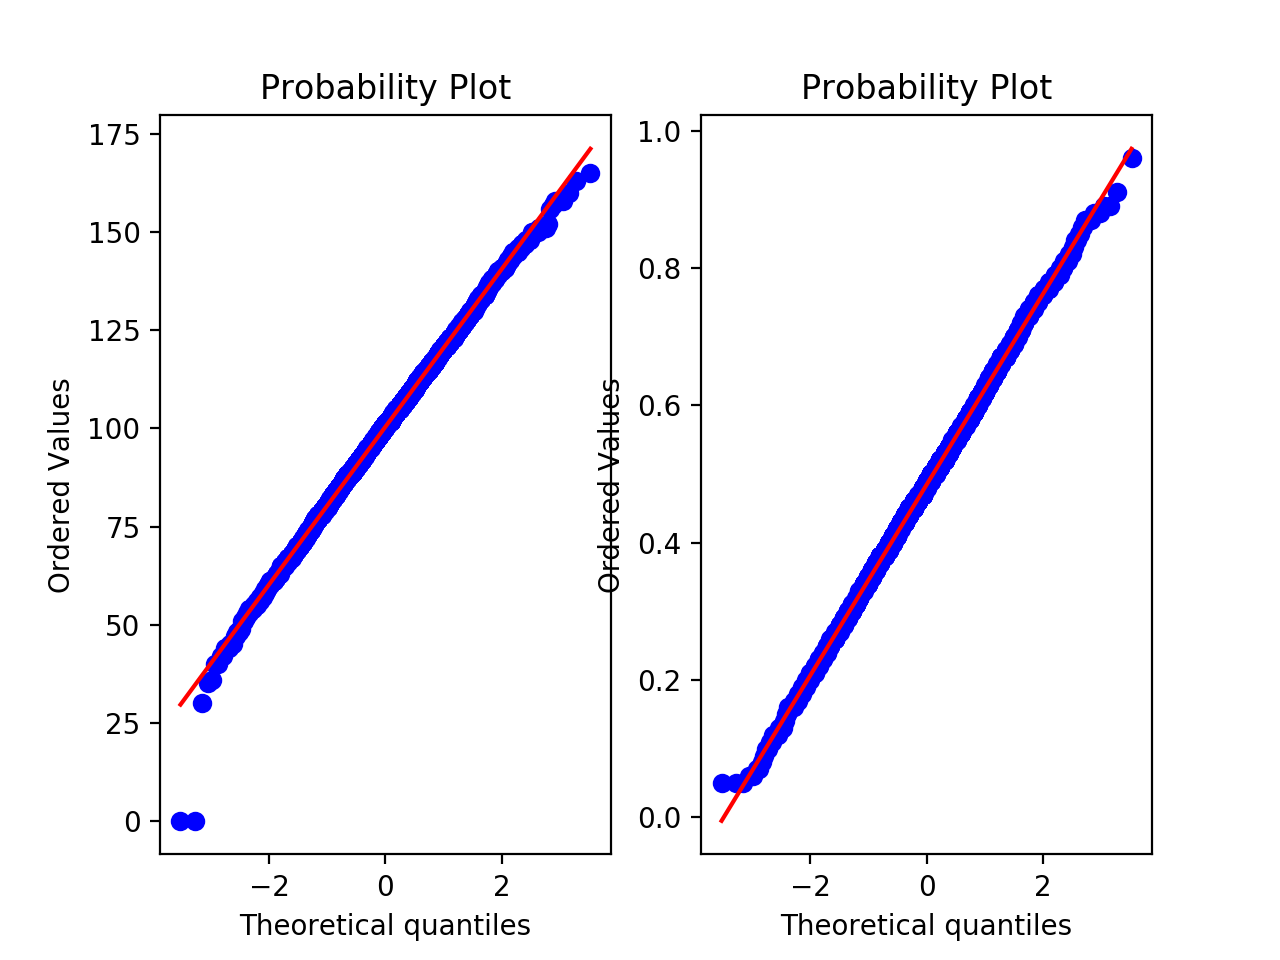

In [37]:
from matplotlib import pyplot

%matplotlib notebook

pyplot.figs
pyplot.subplot(1, 2, 1)
stats.probplot(dataset['day_calls'], dist='norm', plot=pyplot)
pyplot.subplot(1, 2, 2)
stats.probplot(dataset['mes_estim'], dist='norm', plot=pyplot)
pyplot.show()

* Корреляция Пирсона имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.

Еще раз рассмотрим пару признаков `day_calls` и `mes_estim`. Посчитайте корреляцию Спирмена между этими признаками на всех данных, ее значимость.

✅ Отметьте все верные утверждения.

In [32]:
stats.spearmanr(dataset['day_calls'], dataset['mes_estim'])

SpearmanrResult(correlation=0.043349880533927444, pvalue=0.012317367189170541)

* Корреляция Спирмена имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.

✅ Как можно интерпретировать полученные значения коэффициентов корреляции и достигаемые уровни значимости при проверки гипотез о равенстве нулю этих коэффициентов?

* Посчитанные корреляции и их значимости говорят лишь о том, что необходимо взглянуть на данные глазами и попытаться понять, что приводит к таким (противоречивым?) результатам.

❌ Посчитайте значение коэффицента корреляции Крамера между двумя признаками: штатом (`state`) и оттоком пользователей (`churn`) для всех пользователей, которые находились в контрольной группе (`treatment=1`). Что можно сказать о достигаемом уровне значимости при проверке гипотезы о равенство нулю этого коэффициента?

In [62]:
treatment_crosstab.head()

churn,False.,True.
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5


In [64]:
from math import sqrt

def cramers_stat(observed):
    """
    https://stackoverflow.com/a/38032115/359730
    """
    chi2, *_ = stats.chi2_contingency(observed)
    n = observed.sum()
    return sqrt(chi2 / (n * (min(observed.shape) - 1)))


observed = treatment_crosstab.values

chi2, p, dof, expected = stats.chi2_contingency(observed)
print(f'Chi2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'V: {cramers_stat(observed):.4f}')

Chi2: 44.0527
p: 0.7098
V: 0.2004


* Достигаемый уровень значимости > 0.05, то есть, отличие от нуля значения коэффицента Крамера незначимо.
* Для вычисления коэффициента Крамера используется значение статистики xи-квадрат, на которую мы не можем положиться применительно к нашим данным.
* ~~Коэффициент корреляции Крамера не может быть использован для сравнения связи этих двух признаков, потому что он используется для таблиц сопряженности, где каждая из размерностей больше двух. Если хотя бы одна из размерностей равна 2, то нужно использовать коэффициент корреляции Мэтьюса.~~

✅ Вы прослушали большой курс и к текущему моменту обладете достаточными знаниями, чтобы попытаться самостоятельно выбрать нужный метод / инструмент / статистический критерий и сделать правильное заключение.

В этой части задания вам нужно будет самостоятельно решить, с помощью каких методов можно провести анализ эффективности удержания (`churn`) с помощью раличных методов (`treatment = 0`, `treatment = 2`) относительно контрольной группы пользователей (`treatment = 1`).

Что можно сказать об этих двух методах (`treatment = 0`, `treatment = 2`)? Одинаковы ли они с точки зрения эффективности? Каким бы методом вы бы посоветовали воспользоваться компании?

Не забудьте про поправку на множественную проверку! И не пользуйтесь односторонними альтернативами, поскольку вы не знаете, к каким действительно последствиям приводят тестируемые методы (`treatment = 0`, `treatment = 2`)!

In [43]:
treatment_churn_crosstab = pandas.crosstab(dataset['treatment'], dataset['churn'])
treatment_churn_crosstab

churn,False.,True.
treatment,,
0,968,165
1,917,180
2,965,138


In [56]:
_, p, _, _ = stats.chi2_contingency(treatment_churn_crosstab)
p

0.03425399098362844

In [61]:
from statsmodels.stats.proportion import proportion_confint

treatment_0 = dataset[dataset['treatment'] == 0]
treatment_2 = dataset[dataset['treatment'] == 2]

print('Control', proportion_confint(sum(treatment['churn'] == 'True.'), treatment.shape[0], method='wilson'))
print('Treatment 0', proportion_confint(sum(treatment_0['churn'] == 'True.'), treatment_0.shape[0], method='wilson'))
print('Treatment 2', proportion_confint(sum(treatment_2['churn'] == 'True.'), treatment_2.shape[0], method='wilson'))

Control (0.14334706983717693, 0.18716506331819044)
Treatment 0 (0.1262891297794312, 0.16736787598019826)
Treatment 2 (0.1068800961786988, 0.14594875893019524)


In [50]:
_, p = stats.fisher_exact(treatment_churn_crosstab[treatment_churn_crosstab.index.isin([0, 1])])
p

0.2415873393576634

In [51]:
_, p = stats.fisher_exact(treatment_churn_crosstab[treatment_churn_crosstab.index.isin([2, 1])])
p

0.010800363899481705

In [53]:
_, p = stats.fisher_exact(treatment_churn_crosstab[treatment_churn_crosstab.index.isin([0, 2])])
p

0.1739356604490856

* `treatment = 2` статистически значимо отличается от контрольной группы `treatment = 1`
* Отличие между `treatment = 0` и `treatment = 2` относительно влияния на уровень `churn` статистически незначимо.